##Задание
Данные берем отызывы за лето
На вебинаре мы говорили, что долгое время CNN и RNN архитектуры были конурируещими выяснить какая архитектура больше подходит для нашей задачи
1. построить свёрточные архитектуры
2. построить различные архитектуры с RNN
3. построить совместные архитектуры CNN -> RNN или (RNN -> CNN)

Все файлы с данными я выложил на свой гугл диск. Для начала присоединяем google disc

In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 4.8 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


Загружаем данные

In [3]:
import pandas as pd

path = '/content/drive/MyDrive/отзывы за лето.xls'
data = pd.read_excel(path)
data.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


Для удобства работы с НН заменяем лейблы

In [4]:
data['Rating'] = data['Rating'].replace({1: 0, 2: 1, 3: 2, 4: 3, 5: 4})

устанавливаем нужные библиотеки

In [5]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.2 MB/s 
     |████████████████████████████████| 8.2 MB 16.3 MB/s 


In [6]:
!pip install stop_words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=407122c9c4ad0edd76812dcfa5b630496e853d5ee28fadc1ffb8295295c06364
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [7]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Функция для предобработки текста

In [8]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = txt.lower()
    #txt = re.sub("\sне", "не", txt)
    txt = word_tokenize(txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt if word not in sw]
    return " ".join(txt)

Предобрабатываем тексты

In [9]:
data['Content'] = data['Content'].apply(preprocess_text)
data.head()

,Rating,Content,Date
0,4,it just works !,2017-08-14
1,3,целое удобноной приложение ... минус хотеть бо...,2017-08-14
2,4,отлично,2017-08-14
3,4,зависать 1 % работа антивирус . . ранее пользо...,2017-08-14
4,4,"удобно , работать быстро .",2017-08-14


Готовим данные к обучению

In [10]:
train_corpus = " ".join(data["Content"])
tokens = word_tokenize(train_corpus)

In [16]:
#max_words = 5000
max_len = 100
num_classes = 5

# Training
epochs = 5
batch_size = 32
print_batch_n = 100

Создаем словарь уникальных токенов в корпусе

In [11]:
from nltk.probability import FreqDist
dist = FreqDist(tokens)
tokens_freq = [pair[0] for pair in dist.most_common()]

In [12]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_freq, 1)).items()}

функция перевода текста в последовательность с паддингом

In [13]:
import numpy as np

def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

бьем на трейн и тест

In [14]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data['Content'], data['Rating'], test_size=0.33, random_state=42, stratify=data['Rating'])

переводим тексты в трейне в последовательности

In [17]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in x_train], dtype=np.int32)

## Делаем первую часть задания
построить свёрточные архитектуры

In [18]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, SimpleRNN, LSTM, GRU, Masking
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
from keras.metrics import SparseCategoricalAccuracy, categorical_crossentropy 
from keras.callbacks import EarlyStopping  
from keras.losses import SparseCategoricalCrossentropy

In [21]:
model = Sequential()
model.add(Embedding(input_dim=len(vocabulary)+1, output_dim=256, input_length=max_len))
model.add(Conv1D(128, 4))
model.add(Activation("relu"))
model.add(Conv1D(256, 3))
model.add(Activation("relu"))
model.add(Conv1D(256, 2))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.4))
model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [22]:
model.compile(loss='SparseCategoricalCrossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [23]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/5
390/390 [==============================] - 80s 202ms/step - loss: 0.7567 - accuracy: 0.7469 - val_loss: 0.6630 - val_accuracy: 0.7776
Epoch 2/5
390/390 [==============================] - 70s 180ms/step - loss: 0.6230 - accuracy: 0.7836 - val_loss: 0.6669 - val_accuracy: 0.7704
Epoch 3/5
390/390 [==============================] - 71s 183ms/step - loss: 0.5560 - accuracy: 0.8004 - val_loss: 0.6809 - val_accuracy: 0.7740
Epoch 4/5
390/390 [==============================] - 79s 201ms/step - loss: 0.5096 - accuracy: 0.8180 - val_loss: 0.7531 - val_accuracy: 0.7711
Epoch 5/5
390/390 [==============================] - 73s 188ms/step - loss: 0.4693 - accuracy: 0.8372 - val_loss: 0.7762 - val_accuracy: 0.7653


In [24]:
x_test = np.asarray([text_to_sequence(text, max_len) for text in x_test], dtype=np.int32)

In [25]:
import numpy as np
pred = model.predict(x_test, batch_size=batch_size)

In [26]:
pred_label = []
for i in pred:
    pred_label.append(np.argmax(i))

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

print(classification_report(y_test, pred_label))

              precision    recall  f1-score   support

           0       0.50      0.73      0.60       751
           1       0.18      0.02      0.03       247
           2       0.20      0.18      0.19       301
           3       0.27      0.19      0.22       705
           4       0.89      0.92      0.91      4814

    accuracy                           0.76      6818
   macro avg       0.41      0.41      0.39      6818
weighted avg       0.73      0.76      0.74      6818



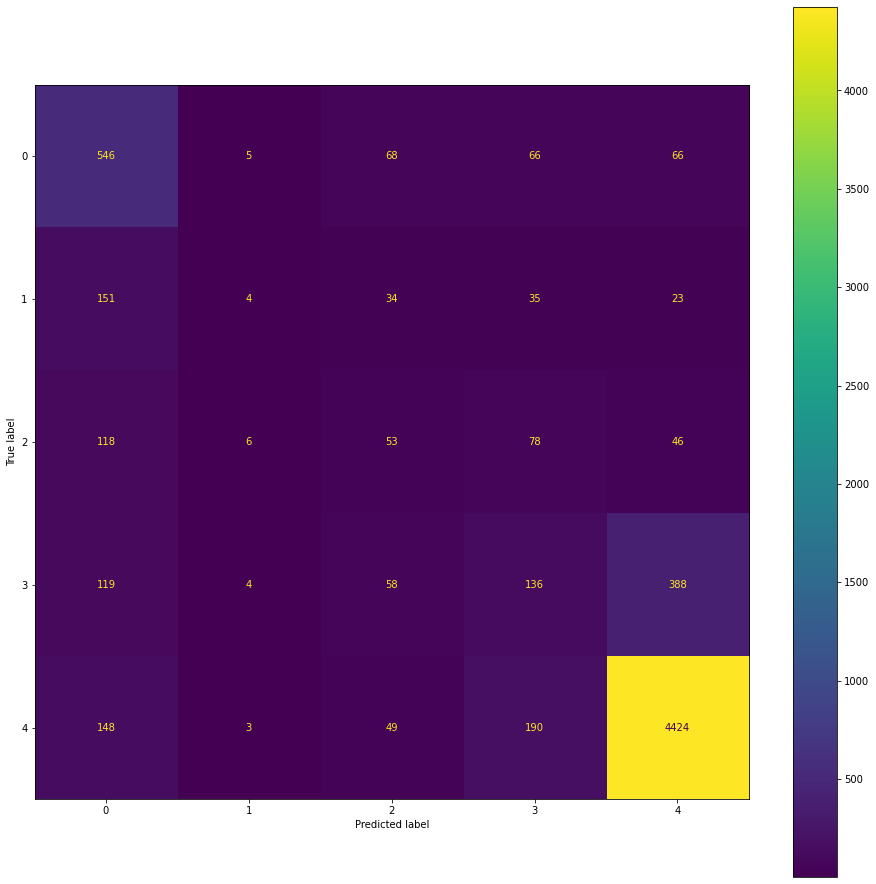

In [28]:
conf_matrix = confusion_matrix(y_test, pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0,1,2,3,4])

fig, ax = plt.subplots(figsize=(16,16))
disp.plot(ax=ax)
plt.show()

## Делем вторую часть задания

Построить различные архитектуры с RNN

In [34]:
model = Sequential()
model.add(
    Embedding(input_dim=len(vocabulary)+1,
              input_length=max_len,
              output_dim=256,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(GRU(128, recurrent_dropout=0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [35]:
model.compile(loss='SparseCategoricalCrossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [36]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/5
390/390 [==============================] - 170s 427ms/step - loss: 0.7575 - accuracy: 0.7481 - val_loss: 0.6603 - val_accuracy: 0.7718
Epoch 2/5
390/390 [==============================] - 143s 366ms/step - loss: 0.6118 - accuracy: 0.7875 - val_loss: 0.6528 - val_accuracy: 0.7755
Epoch 3/5
390/390 [==============================] - 140s 359ms/step - loss: 0.5151 - accuracy: 0.8248 - val_loss: 0.6800 - val_accuracy: 0.7682
Epoch 4/5
390/390 [==============================] - 153s 394ms/step - loss: 0.4398 - accuracy: 0.8528 - val_loss: 0.7197 - val_accuracy: 0.7596
Epoch 5/5
390/390 [==============================] - 141s 361ms/step - loss: 0.3771 - accuracy: 0.8797 - val_loss: 0.7798 - val_accuracy: 0.7531


In [37]:
pred = model.predict(x_test, batch_size=batch_size)

In [38]:
pred_label = []
for i in pred:
    pred_label.append(np.argmax(i))

In [40]:
print(classification_report(y_test, pred_label))

              precision    recall  f1-score   support

           0       0.53      0.54      0.53       751
           1       0.16      0.21      0.18       247
           2       0.21      0.16      0.18       301
           3       0.30      0.15      0.20       705
           4       0.88      0.93      0.90      4814

    accuracy                           0.75      6818
   macro avg       0.41      0.40      0.40      6818
weighted avg       0.72      0.75      0.73      6818



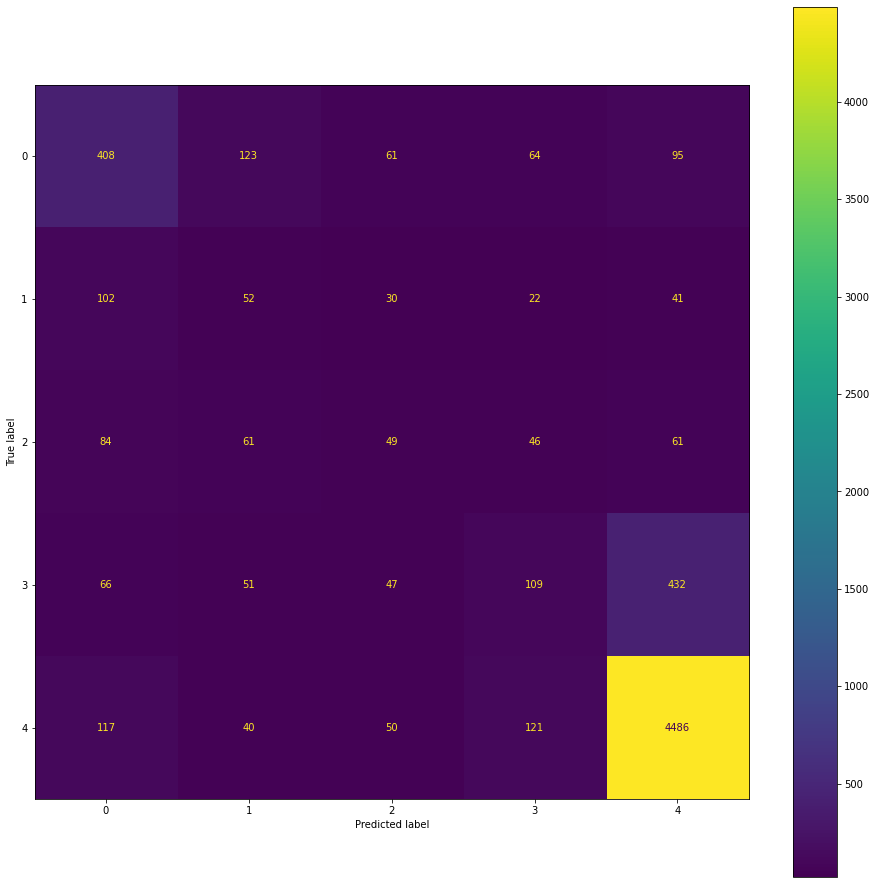

In [41]:
conf_matrix = confusion_matrix(y_test, pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0,1,2,3,4])

fig, ax = plt.subplots(figsize=(16,16))
disp.plot(ax=ax)
plt.show()

In [45]:
from keras.layers import Bidirectional

model = Sequential()
model.add(
    Embedding(input_dim=len(vocabulary)+1,
              input_length=max_len,
              output_dim=256,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
#model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(batch_size, 256)))
model.add(Bidirectional(LSTM(64, recurrent_dropout=0.35)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [46]:
model.compile(loss='SparseCategoricalCrossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [47]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/5
390/390 [==============================] - 150s 372ms/step - loss: 0.7725 - accuracy: 0.7446 - val_loss: 0.6619 - val_accuracy: 0.7661
Epoch 2/5
390/390 [==============================] - 144s 369ms/step - loss: 0.6102 - accuracy: 0.7898 - val_loss: 0.6343 - val_accuracy: 0.7812
Epoch 3/5
390/390 [==============================] - 144s 368ms/step - loss: 0.5250 - accuracy: 0.8202 - val_loss: 0.6920 - val_accuracy: 0.7718
Epoch 4/5
390/390 [==============================] - 142s 363ms/step - loss: 0.4549 - accuracy: 0.8459 - val_loss: 0.7367 - val_accuracy: 0.7718
Epoch 5/5
390/390 [==============================] - 147s 378ms/step - loss: 0.3998 - accuracy: 0.8698 - val_loss: 0.7687 - val_accuracy: 0.7668


In [48]:
pred = model.predict(x_test, batch_size=batch_size)
pred_label = []
for i in pred:
    pred_label.append(np.argmax(i))

In [49]:
print(classification_report(y_test, pred_label))

              precision    recall  f1-score   support

           0       0.54      0.62      0.57       751
           1       0.14      0.15      0.14       247
           2       0.19      0.14      0.16       301
           3       0.29      0.15      0.20       705
           4       0.88      0.93      0.90      4814

    accuracy                           0.75      6818
   macro avg       0.41      0.40      0.40      6818
weighted avg       0.72      0.75      0.73      6818



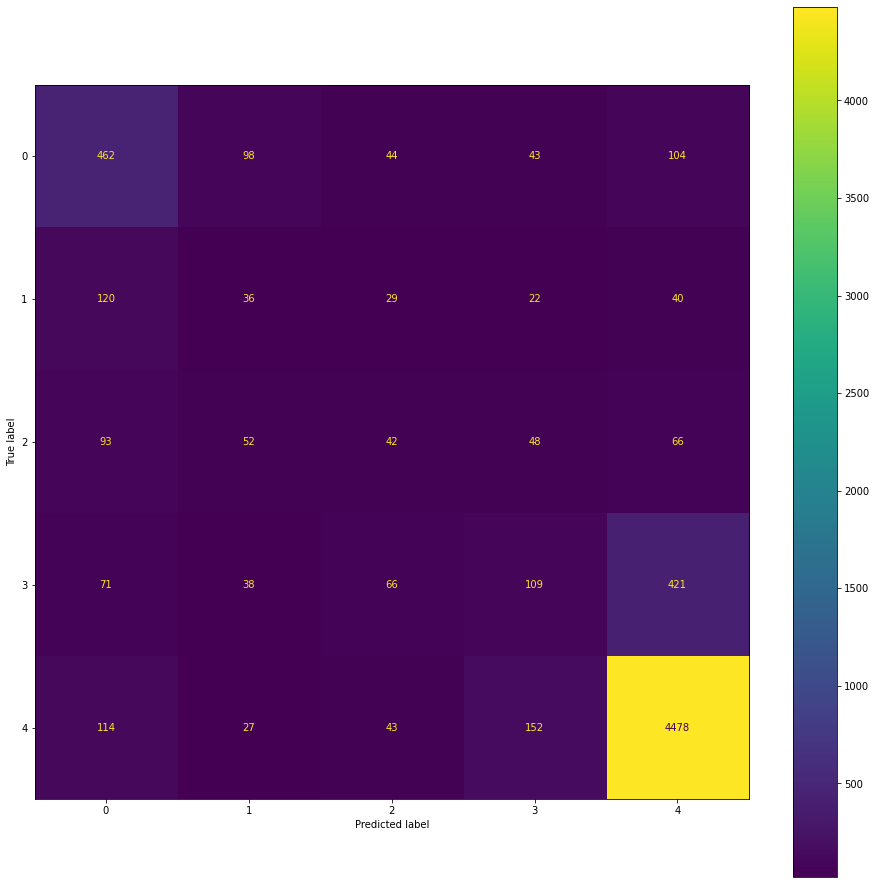

In [50]:
conf_matrix = confusion_matrix(y_test, pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0,1,2,3,4])

fig, ax = plt.subplots(figsize=(16,16))
disp.plot(ax=ax)
plt.show()

## Делаем третью часть задания
построить совместные архитектуры CNN -> RNN

In [56]:
model = Sequential()
model.add(
    Embedding(input_dim=len(vocabulary)+1,
              input_length=max_len,
              output_dim=256,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(Conv1D(128, 4))
model.add(Activation("relu"))
model.add(Conv1D(256, 3))
model.add(Activation("relu"))
model.add(Conv1D(256, 2))
model.add(Activation("relu"))
#model.add(GlobalMaxPool1D())
model.add(Bidirectional(LSTM(64, recurrent_dropout=0.35, input_shape=(batch_size, 256))))
model.add(Dropout(0.4))
model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [57]:
model.compile(loss='SparseCategoricalCrossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [58]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/5
390/390 [==============================] - 198s 493ms/step - loss: 0.7384 - accuracy: 0.7518 - val_loss: 0.6629 - val_accuracy: 0.7733
Epoch 2/5
390/390 [==============================] - 184s 471ms/step - loss: 0.6181 - accuracy: 0.7850 - val_loss: 0.6596 - val_accuracy: 0.7718
Epoch 3/5
390/390 [==============================] - 184s 472ms/step - loss: 0.5481 - accuracy: 0.8101 - val_loss: 0.6873 - val_accuracy: 0.7646
Epoch 4/5
390/390 [==============================] - 183s 470ms/step - loss: 0.4822 - accuracy: 0.8332 - val_loss: 0.7465 - val_accuracy: 0.7422
Epoch 5/5
390/390 [==============================] - 200s 512ms/step - loss: 0.4347 - accuracy: 0.8517 - val_loss: 0.7807 - val_accuracy: 0.7466


In [59]:
pred = model.predict(x_test, batch_size=batch_size)
pred_label = []
for i in pred:
    pred_label.append(np.argmax(i))

In [60]:
print(classification_report(y_test, pred_label))

              precision    recall  f1-score   support

           0       0.58      0.52      0.55       751
           1       0.19      0.18      0.18       247
           2       0.18      0.11      0.14       301
           3       0.27      0.25      0.25       705
           4       0.88      0.93      0.90      4814

    accuracy                           0.75      6818
   macro avg       0.42      0.40      0.41      6818
weighted avg       0.73      0.75      0.74      6818



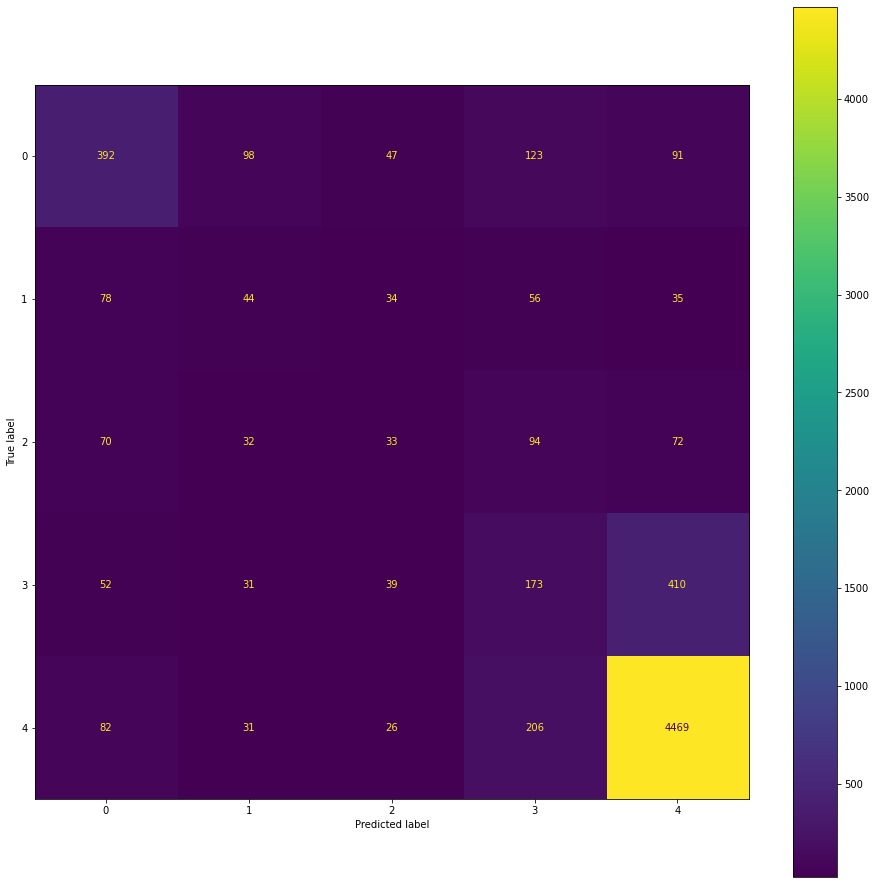

In [61]:
conf_matrix = confusion_matrix(y_test, pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0,1,2,3,4])

fig, ax = plt.subplots(figsize=(16,16))
disp.plot(ax=ax)
plt.show()

## 3. построить совместные архитектуры RNN -> CNN

In [51]:
from keras.layers import Bidirectional, MaxPooling1D, Flatten

model = Sequential()
model.add(
    Embedding(input_dim=len(vocabulary)+1,
              input_length=max_len,
              output_dim=128,
              trainable=True,
              mask_zero=True))
model.add(Bidirectional(LSTM(20, return_sequences=True), 
                 input_shape=(max_len, 128)))
model.add(Bidirectional(LSTM(20, return_sequences=True)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, 3, activation='relu', padding='same'))
model.add(Conv1D(64, 3, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [52]:
model.compile(loss='SparseCategoricalCrossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
input_shape=(batch_size, 128)

In [53]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/5
390/390 [==============================] - 122s 269ms/step - loss: 0.7414 - accuracy: 0.7512 - val_loss: 0.6639 - val_accuracy: 0.7711
Epoch 2/5
390/390 [==============================] - 91s 234ms/step - loss: 0.6140 - accuracy: 0.7856 - val_loss: 0.6723 - val_accuracy: 0.7711
Epoch 3/5
390/390 [==============================] - 105s 268ms/step - loss: 0.5451 - accuracy: 0.8079 - val_loss: 0.7050 - val_accuracy: 0.7653
Epoch 4/5
390/390 [==============================] - 106s 272ms/step - loss: 0.4942 - accuracy: 0.8227 - val_loss: 0.7253 - val_accuracy: 0.7610
Epoch 5/5
390/390 [==============================] - 94s 241ms/step - loss: 0.4471 - accuracy: 0.8462 - val_loss: 0.7807 - val_accuracy: 0.7386


In [54]:
x_test = np.asarray([text_to_sequence(text, max_len) for text in x_test], dtype=np.int32)

In [55]:
pred = model.predict(x_test, batch_size=batch_size)
pred_label = []
for i in pred:
    pred_label.append(np.argmax(i))

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

print(classification_report(y_test, pred_label))

              precision    recall  f1-score   support

           0       0.52      0.62      0.56       751
           1       0.14      0.14      0.14       247
           2       0.23      0.15      0.18       301
           3       0.26      0.26      0.26       705
           4       0.90      0.90      0.90      4814

    accuracy                           0.74      6818
   macro avg       0.41      0.41      0.41      6818
weighted avg       0.74      0.74      0.74      6818



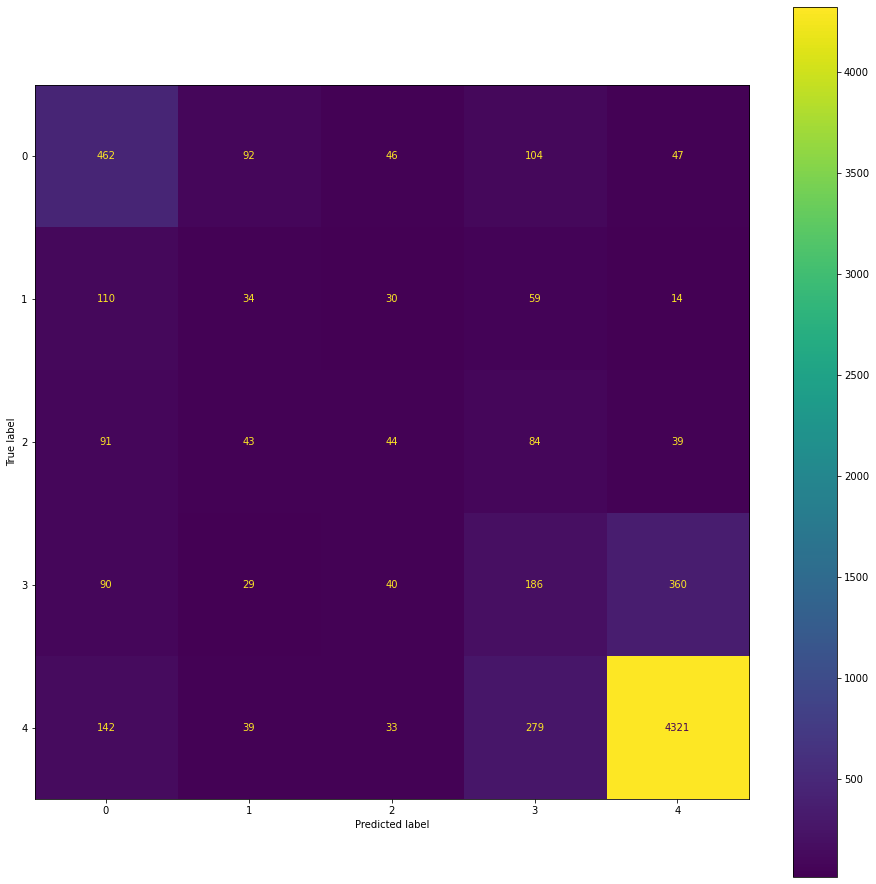

In [58]:
conf_matrix = confusion_matrix(y_test, pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0,1,2,3,4])

fig, ax = plt.subplots(figsize=(16,16))
disp.plot(ax=ax)
plt.show()